In [ ]:
#!pip install basemap

In [3]:
# Import Libraries

import pandas as pd
import numpy as np

import math
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import gc

import pickle

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/content/database.csv')
df.head(3)

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,23412.0,1.679033,30.113183,-77.080000,-18.65300,-3.5685,26.19075,86.005
Longitude,23412.0,39.639961,125.511959,-179.997000,-76.34975,103.9820,145.02625,179.998
Depth,23412.0,70.767911,122.651898,-1.100000,14.52250,33.0000,54.00000,700.000
Depth Error,4461.0,4.993115,4.875184,0.000000,1.80000,3.5000,6.30000,91.295
Depth Seismic Stations,7097.0,275.364098,162.141631,0.000000,146.00000,255.0000,384.00000,934.000
Magnitude,23412.0,5.882531,0.423066,5.500000,5.60000,5.7000,6.00000,9.100
Magnitude Error,327.0,0.071820,0.051466,0.000000,0.04600,0.0590,0.07550,0.410
Magnitude Seismic Stations,2564.0,48.944618,62.943106,0.000000,10.00000,28.0000,66.00000,821.000
Azimuthal Gap,7299.0,44.163532,32.141486,0.000000,24.10000,36.0000,54.00000,360.000
Horizontal Distance,1604.0,3.992660,5.377262,0.004505,0.96875,2.3195,4.72450,37.874


### **Data Cleaning**

In [10]:
date_len = df.Date.str.len()
date_len.value_counts()

10    23409
24        3
Name: Date, dtype: int64

In [11]:
indices = np.where([date_len == 24])[1]
print('Indices with corrupted data:', indices)
df.loc[indices]

Indices with corrupted data: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,1.30,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,NaN,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed


In [12]:
time_len = df.Time.str.len()
time_len.value_counts()

8     23409
24        3
Name: Time, dtype: int64

In [13]:
df.loc[3378, ['Date','Time']] = ['02/23/1975', '02:58:41']
df.loc[7512, ['Date','Time']] = ['04/28/1985', '02:53:41']
df.loc[20650, ['Date','Time']] = ['03/13/2011', '02:23:34']

In [14]:
# Combine the 'Date' and 'Time' columns
df['Datetime'] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)

# Convert the new column to a datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M:%S')

columns = df.columns.tolist() # This code positions 'Datetime' in the first index
columns.remove('Datetime')
columns.insert(0, 'Datetime')
df = df.reindex(columns, axis=1)

df['Datetime'].head()

0   1965-01-02 13:44:18
1   1965-01-04 11:29:49
2   1965-01-05 18:05:58
3   1965-01-08 18:49:43
4   1965-01-09 13:32:50
Name: Datetime, dtype: datetime64[ns]

In [17]:
df = df.drop(['Date','Time'], axis=1)

In [15]:
df['Datetime'].min(), df['Datetime'].max()

(Timestamp('1965-01-02 13:44:18'), Timestamp('2016-12-30 20:08:28'))

In [16]:
df['Type'].value_counts()

Earthquake           23232
Nuclear Explosion      175
Explosion                4
Rock Burst               1
Name: Type, dtype: int64

In [19]:
# Find the columns with null values and their percentage

null_cols = df.columns[df.isnull().any()].tolist()
null_percentages = [np.round(100 * df[col].isnull().mean(), 2) for col in null_cols]

for col, percentage in zip(null_cols, null_percentages):
    print(f"{col}: {percentage}%")

Depth Error: 80.95%
Depth Seismic Stations: 69.69%
Magnitude Type: 0.01%
Magnitude Error: 98.6%
Magnitude Seismic Stations: 89.05%
Azimuthal Gap: 68.82%
Horizontal Distance: 93.15%
Horizontal Error: 95.06%
Root Mean Square: 25.88%


All variables except Magnitude Type that have null values need to be dropped because filling them would make our analysis unreliable.

In [20]:
# Drop columns

cols_to_drop = [col for col in null_cols if col != 'Magnitude Type'] +['ID','Source','Location Source','Magnitude Source','Status'] # ID, sources and status do not add much information for analysis
df = df.drop(cols_to_drop, axis=1)
df.head(2)

,Datetime,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW
1,1965-01-04 11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW


In [21]:
mode = df['Magnitude Type'].mode()[0]

# Fill missing values in the column with the mode
df['Magnitude Type'] = df['Magnitude Type'].fillna(mode)

In [22]:
# Dropping duplicates

df = df[~df.index.duplicated(keep=False)]

In [23]:
gc.collect()

55

### **Exploratory Analysis**

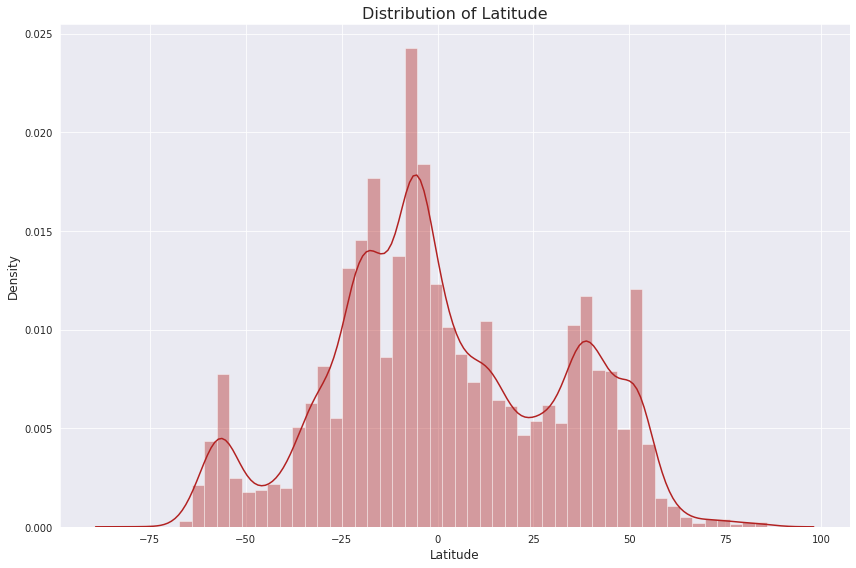

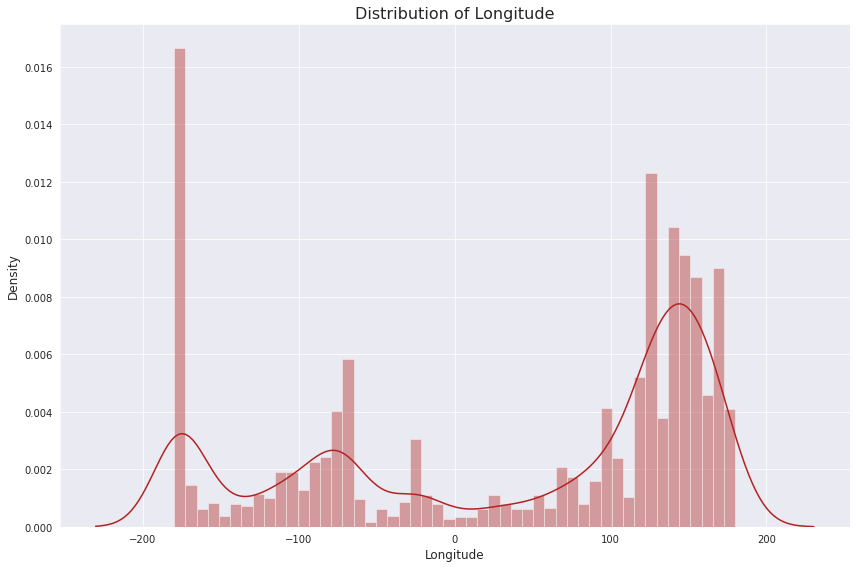

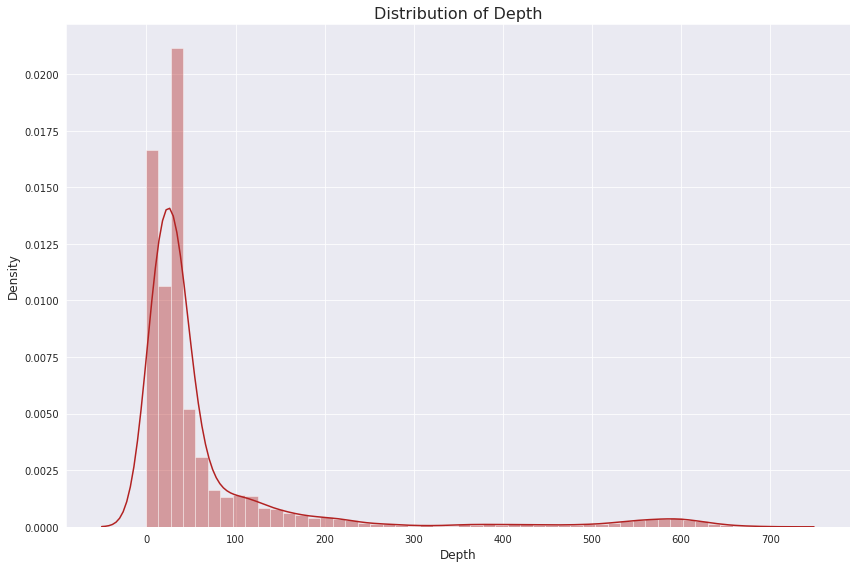

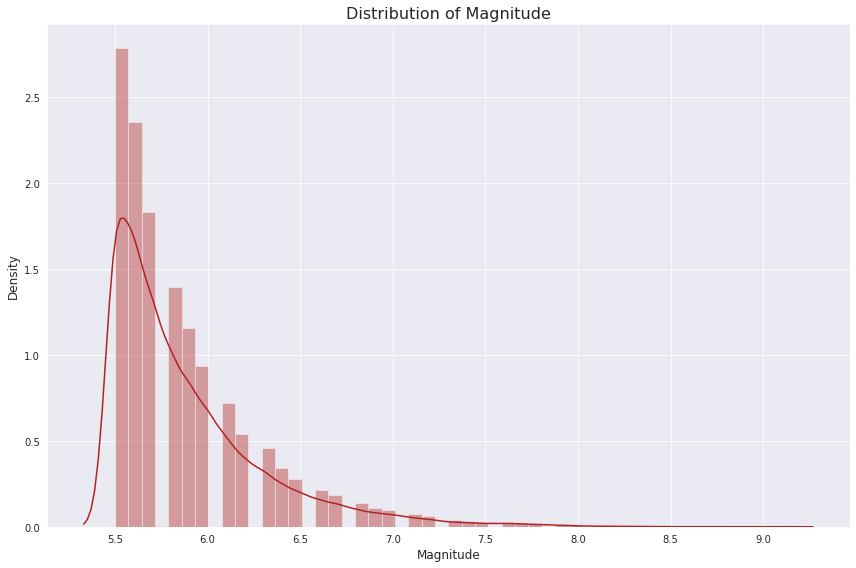

In [24]:
# Plot the distribution of numerical variables

sns.set_style("darkgrid")

for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(12, 8))
    sns.distplot(df[column], bins=50, color='firebrick')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'Distribution of {column}', fontsize=16)
    plt.tight_layout()
    plt.show()


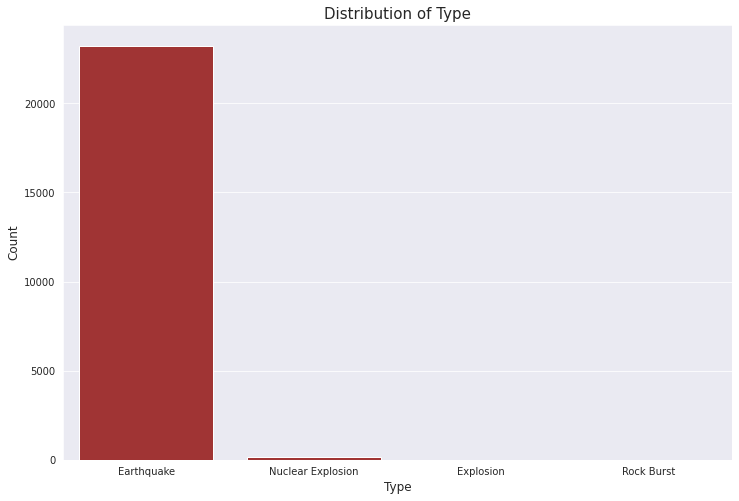

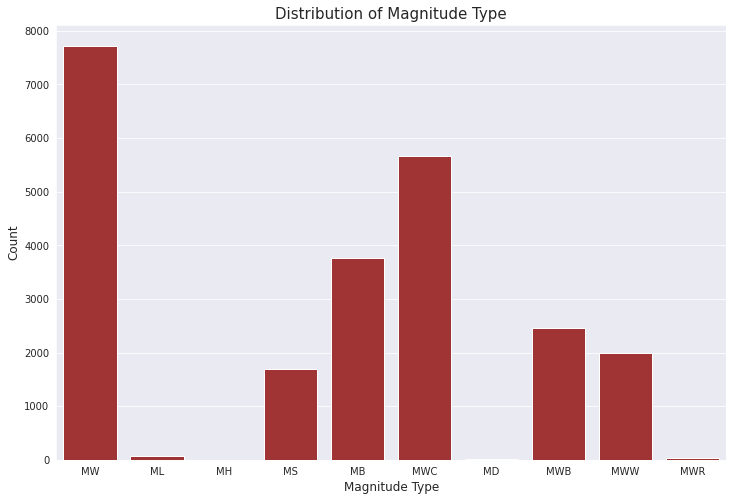

In [25]:
# Plot the distribution of categorical variables

for column in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(12, 8))
    sns.countplot(x=column, data=df, color='firebrick')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.show()


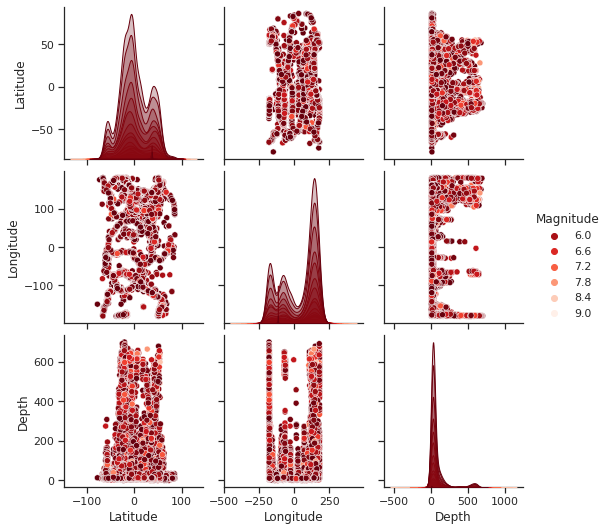

In [26]:
# Create scatter plot matrix

sns.set(style="ticks", color_codes=True)
sns.pairplot(df, hue='Magnitude', palette='Reds_r')
plt.show()

**Findings:**

1. Most of the events have taken place between 10 to 5 degrees south of the equator and 115-175 degrees east of the prime meridian. The least number of earthquakes are along the prime meridian give and take 5 degrees and 75-80 degrees north and south of the equator. This means a lot of earhquakes occur along the prime meridian but away from the equator.
2. The distribution of magnitude and depth is heavily skewed to the right with most events in the range of 5.5-6 magnitude and 0-40 in depth.
3. There are negative values in depth which indicates that earthquakes occurred above the Earth's surface. This can occur in areas where the Earth's surface is unstable, such as those near active volcanic regions, where magma and ash can cause the ground to shake and produce earthquakes.
4. The type of event with the most records in this dataset is earthquakes. We will drop rows with other events since they are only 180 and the goal is to predict earthquakes. 
5. The magnitude type that has the highest frequency is MW followed by MWC

### **Pre-Processing**

In [27]:
# Check the skewness of 'Magnitude' and 'Depth'

print('Skewness of Magnitude:', df['Magnitude'].skew())
print('Skewness of Depth:', df['Depth'].skew())

Skewness of Magnitude: 1.848345706336882
Skewness of Depth: 3.2906825734888336


Both variables are highly skewed hence we will perform log transformation

In [28]:
df['Depth'] = np.log(df['Depth'] + 1)

In [ ]:
# Filter the data to only include events with type == "Earthquake"

df = df[df['Type'] == "Earthquake"]
df = df.drop('Type', axis=1)

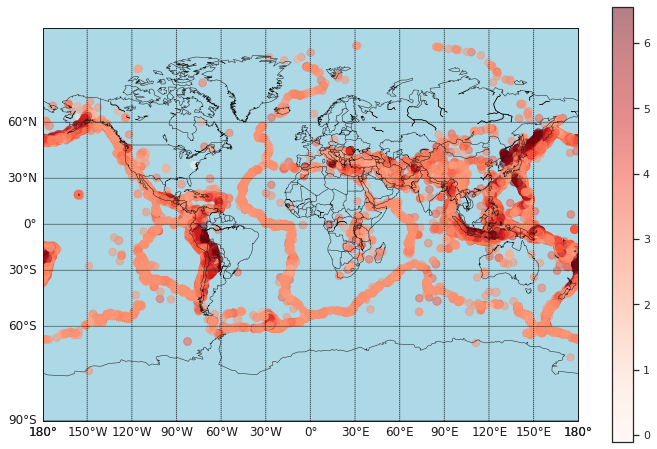

In [30]:
fig = plt.figure(figsize=(12, 8))

# Create basemap object
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

# draw coastlines, country boundaries, and grid lines
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawmapboundary(fill_color='lightblue')
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,1])
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])

# convert latitudes and longitudes to x and y coordinates
x, y = m(df['Longitude'].values, df['Latitude'].values)

# plot earthquakes on map with size based on magnitude and color based on depth
points = m.scatter(x, y, s=10*df['Magnitude'].values, c=df['Depth'].values, cmap='Reds', alpha=0.5)

plt.colorbar(points)
plt.show();

Earthquakes occur where the tectonic plates that make up the Earth's crust meet and interact with each other. Many of these tectonic plate boundaries occur in the ocean, which explains why there are earthquakes in the ocean. Additionally, earthquakes are more likely to occur along coastlines because many of these areas are also located near tectonic plate boundaries.

In [31]:
# Calculate the geographical distance between consecutive earthquakes,

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return 6371 * 2 * np.arcsin(np.sqrt(a))

# Calculate the new variable 'Distance'
df['Distance'] = haversine_np(df['Longitude'].shift(), df['Latitude'].shift(), df['Longitude'], df['Latitude'])
df['Distance'] = round(df['Distance'], 4)
df.head(2)

,Datetime,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Distance
0,1965-01-02 13:44:18,19.246,145.616,4.887337,6.0,MW,NaN
1,1965-01-04 11:29:49,1.863,127.352,4.394449,5.8,MW,2772.5613


In [32]:
df['Distance'].describe()

count    23231.000000
mean      7349.109161
std       5361.178719
min          0.000000
25%       2627.511950
50%       7025.910700
75%      11383.551300
max      19841.387800
Name: Distance, dtype: float64

In [33]:
# Drop the null row created by the 'Distance' 

df = df.dropna(axis=0)

**Temporal Analysis**

In [34]:
# Create hour, day month and year variables from the 'Datetime' column

df['Hour'] = df.Datetime.dt.hour
df['Day'] = df.Datetime.dt.day_name()
df['Month'] = df.Datetime.dt.strftime('%B')
df['Year'] = df.Datetime.dt.year


# Drop the 'Datetime' column
df = df.drop('Datetime', axis=1)

df.tail(2)

,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Distance,Hour,Day,Month,Year
23410,-9.0283,118.6639,4.382027,6.3,MWW,5590.6910,22,Thursday,December,2016
23411,37.3973,141.4103,2.560323,5.5,MB,5679.5166,20,Friday,December,2016


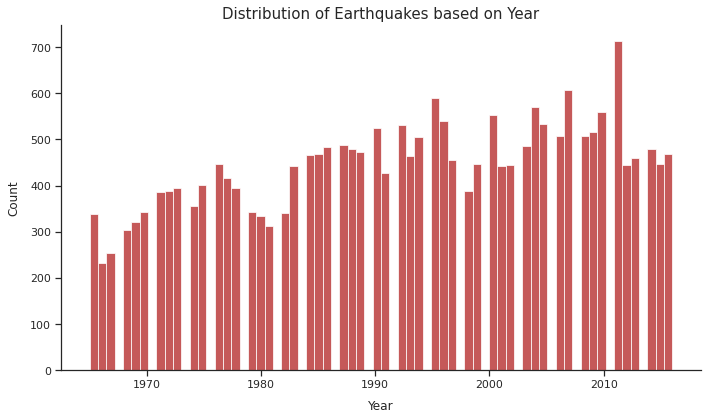

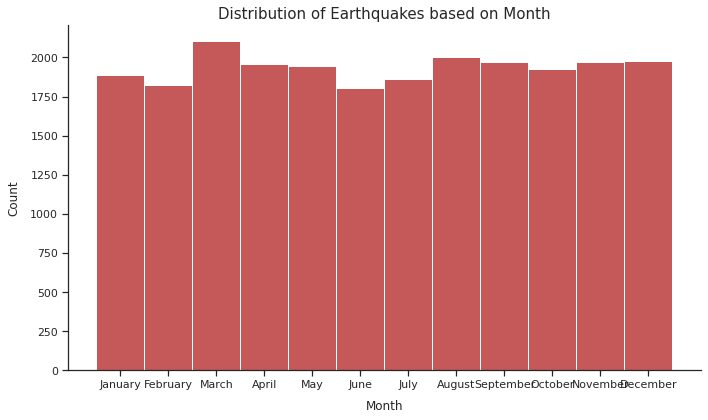

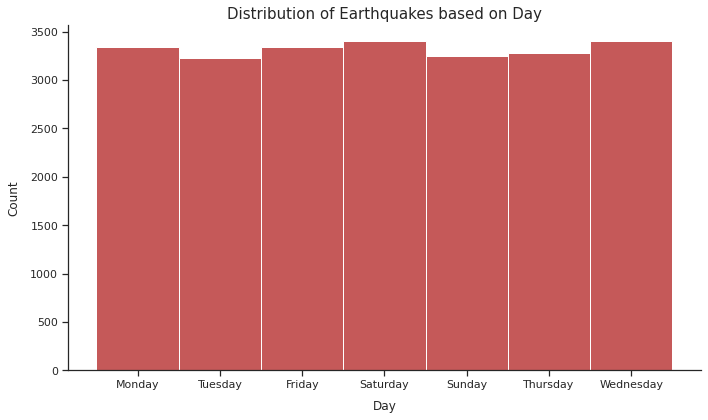

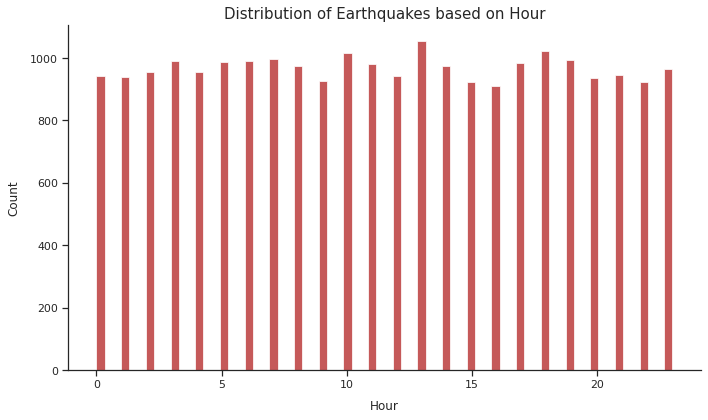

In [ ]:
# Create separate plots for each of the 'Year', 'Month', 'Day' and 'Hour' columns

for column in ['Year', 'Month', 'Day', 'Hour']:
    plt.figure(figsize=(10,6))
    sns.histplot(df[column], bins=70, color='firebrick', kde=False)
    plt.xlabel(column, fontsize=12, labelpad=10)
    plt.ylabel('Count', fontsize=12, labelpad=10)
    plt.title(f'Distribution of Earthquakes based on {column}', fontsize=15)
    plt.tight_layout()
    sns.despine()
    plt.show()


Conclusion:
1. 2011 had the highest number of earthquakes recorded : 713, while the least was 1966 with 233 which would be because there were those not recorded in the earlier years. 
2. March had more records with 2104 cases while June had the least number of cases with 1807. 
3. The 11th day of the month is the most likely to experience an earthquake since it has the highest number with 900, followed by the 17 th day with 840 while the 31st is least likely to have an earthquake since it has 345 cases.
4. The 13 hour of the day is most likely to have an earthquake with 1055 cases while the 16 hour is the least likely with 909 cases.

In [35]:
df['Magnitude Type'].value_counts()

MW     7724
MWC    5668
MB     3594
MWB    2458
MWW    1983
MS     1702
ML       64
MWR      26
MD        6
MH        5
Name: Magnitude Type, dtype: int64

In [36]:
# Group categories with frequency less than 1000

other_cutoff = 1000
df['Magnitude Type'] = np.where(df['Magnitude Type'].isin(df['Magnitude Type'].value_counts()[df['Magnitude Type'].value_counts() < other_cutoff].index), 'Other', df['Magnitude Type'])

# Print the reduced categories
print(df['Magnitude Type'].value_counts())


MW       7724
MWC      5668
MB       3594
MWB      2458
MWW      1983
MS       1702
Other     101
Name: Magnitude Type, dtype: int64


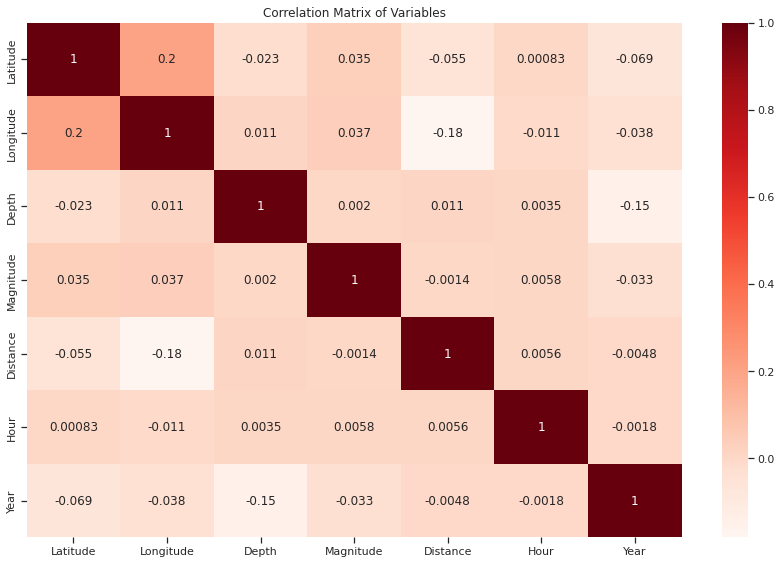

In [ ]:
# Create a correlation matrix
corr = df.corr()

# Plot the heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='Reds', annot=True)
plt.title('Correlation Matrix of Variables')
plt.tight_layout()

plt.show()

In [37]:
# Encode the categorical features

df = pd.get_dummies(df)
df.head(3)

,Latitude,Longitude,Depth,Magnitude,Distance,Hour,Year,Magnitude Type_MB,Magnitude Type_MS,Magnitude Type_MW,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
1,1.863,127.352,4.394449,5.8,2772.5613,11,1965,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,-20.579,-173.972,3.044522,6.2,6853.9942,18,1965,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,-59.076,-23.557,2.772589,5.8,10753.6999,18,1965,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [38]:
gc.collect()

0

## **Modeling**

In [39]:
# Split into features and target 

X = df.drop('Magnitude', axis=1)
y = df['Magnitude']

# Split the data into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
scaler = StandardScaler()

# Remove 'Depth' from X_train and X_test
X_train_scaled = X_train.drop(columns=['Depth'])  # Depth has been log transformed
X_test_scaled = X_test.drop(columns=['Depth'])

# Scale the remaining features

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Combine the scaled features with the scaled 'Depth' column

X_train_scaled = np.hstack((X_train_scaled, X_train['Depth'].values.reshape(-1, 1)))
X_test_scaled = np.hstack((X_test_scaled, X_test['Depth'].values.reshape(-1, 1)))

In [41]:
# Log-transform the y variable on the training set

y_train = np.log(y_train)

In [42]:
# create new dataframes with the scaled data and original column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16261, 32), (16261, 1), (6969, 32), (6969, 1))

In [44]:
X_train.columns

Index(['Latitude', 'Longitude', 'Depth', 'Distance', 'Hour', 'Year',
       'Magnitude Type_MB', 'Magnitude Type_MS', 'Magnitude Type_MW',
       'Magnitude Type_MWB', 'Magnitude Type_MWC', 'Magnitude Type_MWW',
       'Magnitude Type_Other', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September'],
      dtype='object')

In [45]:
gc.collect()

0

### **Hyperparameter tuning**

Halving Random Search Cross Validation was used to tune the hyperparameters of the different models

**Random Forest Regressor**

In [ ]:
# Create the random forest regressor object
rf = RandomForestRegressor()

# Define the parameter space for hyperparameter tuning
param_dist = {"n_estimators": randint(100, 500),
              "max_features": randint(1, 10),
              "max_depth": [None] + list(range(1, 11)),
              "min_samples_leaf": randint(1, 10)}

# Create the halving random search cross-validation object and fit 
hrscv = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist, 
                              n_candidates=100, min_resources = 'exhaust', factor=2,
                              random_state=42, n_jobs=-1)

hrscv.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters for Random Forest Regressor: {hrscv.best_params_}")

Best hyperparameters for Random Forest Regressor: {'max_depth': None, 'max_features': 9, 'min_samples_leaf': 6, 'n_estimators': 448}


In [46]:
# Create and train the model using the tuned hyperparameters
rf = RandomForestRegressor(max_features = 9, min_samples_leaf = 6, n_estimators = 448, random_state=42)
rf.fit(X_train, y_train)
 
# Predictions
rf_pred = rf.predict(X_test)

# Back-transform predicted values to original scale
y_pred_orig = np.exp(rf_pred)

# Evaluate the model 
mae = mean_absolute_error(y_test, y_pred_orig)
mse= mean_squared_error(y_test, y_pred_orig)
rmse = np.sqrt(mse)

print("Mean Absolute Error: {:.6f}".format(mae))
print("Mean Squared Error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean Absolute Error: 0.281144
Mean Squared Error: 0.150761
Root Mean Squared Error :0.388279


**Gradient Boosting Regressor**

In [ ]:
# Create a Gradient Boosting Regressor object
gbr = GradientBoostingRegressor()

# Define the hyperparameter space
param_dist = {"n_estimators": randint(100, 500),
              "max_features": randint(1, 10),
              "max_depth": [None] + list(randint(1, 11).rvs(10)),
              "min_samples_leaf": randint(1, 10)}


# Define the Halving Random Search cross-validation object
hrscv = HalvingRandomSearchCV(gbr, param_distributions=param_dist, n_candidates=100,
                              factor=2, min_resources='exhaust', 
                              random_state=42, n_jobs=-1)

# Fit the Halving Random Search cross-validation object to the data 
hrscv.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters for Gradient Boosting Regressor: {hrscv.best_params_}")

Best hyperparameters for Gradient Boosting Regressor: {'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 8, 'n_estimators': 134}


In [47]:
# Create and train the model with the tuned hyperparameters
gbr = GradientBoostingRegressor(max_depth = 4, max_features = 7, min_samples_leaf = 8, n_estimators = 134, random_state=42)
gbr.fit(X_train, y_train)

# Predictions
gbr_pred = gbr.predict(X_test)

# Back-transform predicted values to original scale
y_pred_orig = np.exp(gbr_pred)

# Evaluate the model 
mae = mean_absolute_error(y_test, y_pred_orig)
mse= mean_squared_error(y_test, y_pred_orig)
rmse = np.sqrt(mse)

print("Mean Absolute Error: {:.6f}".format(mae))
print("Mean Squared Error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean Absolute Error: 0.282406
Mean Squared Error: 0.151731
Root Mean Squared Error :0.389527


**Decision Tree Regressor**

In [ ]:
# Create a decision tree regressor object
dt = DecisionTreeRegressor()

# Define the hyperparameter space
param_dist = {"max_depth": [None] + list(randint(1, 11).rvs(10)),
              "max_features": randint(1, 10),
              "min_samples_split": randint(2, 20),
              "min_samples_leaf": randint(1, 20)}

# Define the halving random search cross-validation object
hrscv = HalvingRandomSearchCV(dt, param_distributions=param_dist, 
                              factor=2, min_resources='exhaust',
                              n_candidates=100, n_jobs= -1, random_state=42)
                             
# Fit the halving random search cross-validation object to the data
hrscv.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean test score
print("Best hyperparameters for Decision Tree Regressor: ", hrscv.best_params_)
     

Best hyperparameters for Decision Tree Regressor:  {'max_depth': 2, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 7}


In [48]:
# Create and train the model with the tuned hyperparameters
dt = DecisionTreeRegressor(max_depth = 2, max_features = 7, min_samples_leaf = 4, min_samples_split = 7, random_state=42)
dt.fit(X_train, y_train)

# Predictions
dt_pred = dt.predict(X_test)

# Back-transform the predictions using the exponential function
y_pred_orig = np.exp(dt_pred)

# Evaluate the model 
mae = mean_absolute_error(y_test, y_pred_orig)
mse= mean_squared_error(y_test, y_pred_orig)
rmse = np.sqrt(mse)

print("Mean Absolute Error: {:.6f}".format(mae))
print("Mean Squared Error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean Absolute Error: 0.297694
Mean Squared Error: 0.166197
Root Mean Squared Error :0.407672


After tuning the hyperparameters, Random Forest has the best performance overall. It has the least MAE, MSE and RMSE.

### **Feature Importance**

In [49]:
# Extract the feature importances as a dictionary 

model = RandomForestRegressor(max_features = 9, min_samples_leaf = 6, n_estimators = 448, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

importances_dict = dict(zip(X_train.columns, importances))

print("Random Forest feature importances:")
for feature, importance in sorted(importances_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Random Forest feature importances:
Month_September: 0.1504
Hour: 0.1493
Longitude: 0.1307
Latitude: 0.1227
Depth: 0.1187
Year: 0.0847
Distance: 0.0801
Magnitude Type_MWC: 0.0169
Magnitude Type_MS: 0.0114
Magnitude Type_MWB: 0.0105
Magnitude Type_MB: 0.0100
Magnitude Type_MW: 0.0092
Day_Tuesday: 0.0082
Day_Monday: 0.0077
Day_Friday: 0.0077
Day_Saturday: 0.0071
Magnitude Type_Other: 0.0071
Day_Sunday: 0.0069
Day_Thursday: 0.0063
Month_May: 0.0053
Month_June: 0.0051
Month_January: 0.0047
Month_November: 0.0046
Day_Wednesday: 0.0046
Month_April: 0.0046
Month_July: 0.0044
Month_October: 0.0044
Month_March: 0.0044
Month_August: 0.0044
Month_February: 0.0038
Month_December: 0.0036
Magnitude Type_MWW: 0.0004


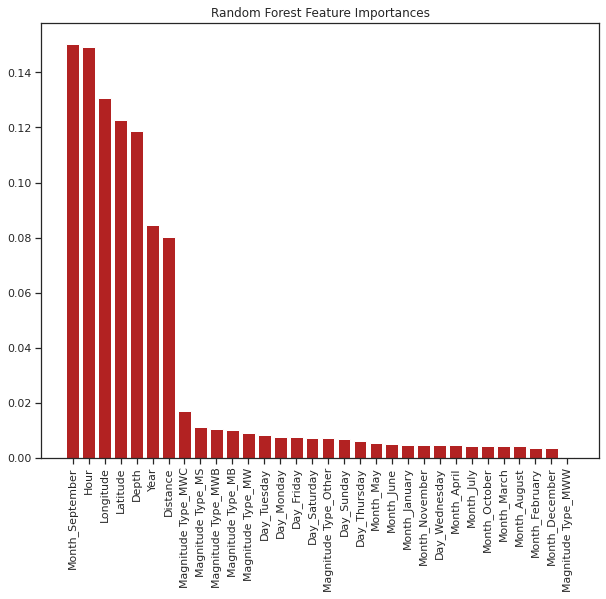

In [50]:
# Plot feature importances

importances_sorted = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*importances_sorted)

plt.figure(figsize=(10,8))
plt.bar(features, importances, color='firebrick')
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importances")
plt.show()

**Observations**

Based on the feature importance from our model, it appears that the hour of the day, month of the year (specifically September), and the location of the earthquake (longitude, latitude, and depth) have the highest impact on the earthquake magnitude. 


This suggests that earthquakes are more likely to occur during certain times of the day and year, and that the location and depth of the earthquake play a significant role in determining its magnitude.


All month features except month-September have low feature importance scores which is interesting because September does not have the highest count of earthquakes.

In [51]:
# Select k features based on feature importances

k = 32
importances = np.array(importances)
top_k = importances.argsort()[::-1][:k]

X_train_top_k = X_train.iloc[:, top_k]
X_test_top_k = X_test.iloc[:, top_k]

# Train model on selected features
model.fit(X_train_top_k, y_train)

# Predictions
y_pred_top_k = model.predict(X_test_top_k)

# Back-transform the predictions using the exponential function
y_pred_orig = np.exp(y_pred_top_k)

# Evaluate the model 
mae = mean_absolute_error(y_test, y_pred_orig)
mse= mean_squared_error(y_test, y_pred_orig)
rmse = np.sqrt(mse)

print("Mean Absolute Error: {:.6f}".format(mae))
print("Mean Squared Error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean Absolute Error: 0.281144
Mean Squared Error: 0.150761
Root Mean Squared Error :0.388279


The Random Forest Regressor performs best with all 32 features. Reducing the number worsens its performance.

In [52]:
gc.collect()

6834

In [ ]:
# Save the model

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)